---
title: Gradient Considerations
date: 2023-04-01
authors:
  - name: J. Emmanuel Johnson
    affiliations:
      - MEOM Lab
    roles:
      - Primary Programmer
    email: jemanjohnson34@gmail.com
license: CC-BY-4.0
keywords: NerFs, Images
---

In [1]:
import sys, os

# spyder up to find the root
oceanbench_root = "/gpfswork/rech/cli/uvo53rl/projects/oceanbench"

# append to path
sys.path.append(str(oceanbench_root))

In [2]:
import autoroot
import typing as tp
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import wandb
from omegaconf import OmegaConf
import hydra
import metpy


sns.reset_defaults()
sns.set_context(context="poster", font_scale=0.7)

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Processing Chain

**Part I**:

* Open Dataset
* Validate Coordinates + Variables
* Decode Time
* Select Region
* Sortby Time

**Part II**: Regrid

**Part III**:

* Interpolate Nans
* Add Units
* Spatial Rescale
* Time Rescale

**Part IV**: Metrics

*

## Data

In [3]:
# !wget wget -nc https://s3.us-east-1.wasabisys.com/melody/osse_data/ref/NATL60-CJM165_GULFSTREAM_ssh_y2013.1y.nc

In [4]:
!ls /gpfswork/rech/yrf/commun/data_challenges/dc20a_osse/staging/results/DUACS

2020a_SSH_mapping_NATL60_DUACS_en_j1_tpn_g2.nc	     ssh_DUACS_swot_4nadir.nc
2020a_SSH_mapping_NATL60_DUACS_swot_en_j1_tpn_g2.nc  ssh_DUACS_swot.nc
ssh_DUACS_4nadir.nc


In [5]:
# !cat configs/postprocess.yaml

In [6]:
# # load config
# config_dm = OmegaConf.load('./configs/postprocess.yaml')

# # instantiate
# ds = hydra.utils.instantiate(config_dm.NATL60_GF_1Y1D)
# ds

In [12]:
!ls /gpfswork/rech/cli/uvo53rl/projects/jejeqx/data/natl60/

dataset_nadir_0d.nc
dataset_nadir_0d_swot.nc
dataset_swot.nc
NATL60-CJM165_GULFSTREAM_ssh_y2013.1y.nc
NATL60-CJM165_GULFSTREAM_sss_y2013.1y.nc
NATL60-CJM165_GULFSTREAM_sst_y2013.1y.nc
ssh_NATL60_4nadir.nc
ssh_NATL60_swot_4nadir.nc
ssh_NATL60_swot.nc


In [ ]:
ds_natl60 = xr.open_dataset("/gpfswork/rech/cli/uvo53rl/projects/jejeqx/data/natl60/NATL60-CJM165_GULFSTREAM_sst_y2013.1y.nc")
ds_natl60

<xarray.Dataset>
Dimensions:  (time: 365, lat: 201, lon: 201)
Coordinates:
  * time     (time) datetime64[ns] 2012-10-01T12:00:00 ... 2013-09-30T12:00:00
  * lon      (lon) float64 -65.0 -64.95 -64.9 -64.85 ... -55.1 -55.05 -55.0
  * lat      (lat) float64 33.0 33.05 33.1 33.15 33.2 ... 42.85 42.9 42.95 43.0
Data variables:
    sss      (time, lat, lon) float64 ...
Attributes:
    regrid_method:  bilinear

In [ ]:
from matplotlib import ticker

def plot_sst_map(ds, variable: str="ssh", **kwargs):
    
    fig, ax = plt.subplots(figsize=(7,5.5))
    vmin=kwargs.pop("vmin", ds[variable].min().values)
    vmax=kwargs.pop("vmax", ds[variable].max().values)
    cmap=kwargs.pop("cmap", "RdBu_r")
    levels = kwargs.pop("levels", 5)
        
    ds[variable].squeeze().plot.pcolormesh(
        ax=ax, vmin=vmin, vmax=vmax, cmap=cmap,
        cbar_kwargs=kwargs.pop("cbar_kwargs", None),
        **kwargs,
    )
    # loc = ticker.MaxNLocator(levels)
    # levels = loc.tick_values(ds[variable].min().values, ds[variable].max().values)
    # ds[variable].squeeze().plot.contour(
    #     ax=ax, 
    #     alpha=0.5, linewidths=1, cmap="black",
    #     levels=levels,
    #     linestyles=np.where(levels >= 0, "-", "--")
    #     # vmin=vmin, vmax=vmax,
    #     # **kwargs
    # )    
    ax.set_title(pd.to_datetime(ds.time.values).strftime('%Y-%m-%d'))
    fig.tight_layout()
    
    return fig, ax

In [63]:
def correct_sst_labels(ds):
    
    ds["lon"].attrs["units"] = "degrees"
    ds["lat"].attrs["units"] = "degrees"
    ds["sst"].attrs["units"] = "°C"
    ds["sst"].attrs["standard_name"] = "sea_surface_temperature"
    ds["sst"].attrs["long_name"] = "Sea Surface Temperature"
    ds["lon"].attrs["standard_name"] = "longitude"
    ds["lat"].attrs["standard_name"] = "latitude"
    ds["lat"].attrs["long_name"] = "Latitude"
    ds["lon"].attrs["long_name"] = "Longitude"
    
    return ds
    

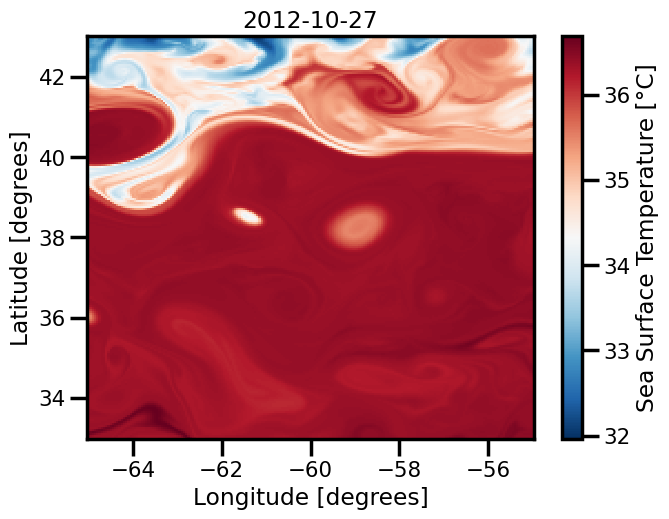

In [65]:
fig, ax = plot_sst_map(correct_sst_labels(ds_natl60.sel(time="2012-10-27")), variable="sst")

ax.set(title="2012-10-27")
plt.tight_layout()
fig.savefig("./figures/maps/dc20a_nemo_sst.png")

## Reference Dataset

For the reference dataset, we will look at the NEMO simulation of the Gulfstream. We will look at a preprocessed version.

In [66]:
%%writefile configs/natl60.yaml

domain:
  lat: {_target_: "builtins.slice", _args_: [32., 44.]}
  lon: {_target_: "builtins.slice", _args_: [-66., -54.]}
  time: {_target_: "builtins.slice", _args_: ["2012-10-22", "2012-12-02"]}

select:
    _target_: "xarray.Dataset.sel"
    _partial_: True
    indexers: "${domain}"

# NATL60 GULFSTREAM SIMULATION - REDUCED VERSION
NATL60_GF_1Y1D:
  _target_: "oceanbench._src.data.pipe"
  inp: "/gpfswork/rech/cli/uvo53rl/projects/jejeqx/data/natl60/NATL60-CJM165_GULFSTREAM_ssh_y2013.1y.nc"
  fns:
    - {_target_: "xarray.open_dataset", decode_times: False, _partial_: True}
    # VALIDATE COORDINATES
    - {_target_: "oceanbench._src.geoprocessing.validation.validate_latlon", _partial_: True}
    - {_target_: "oceanbench._src.geoprocessing.validation.validate_time", _partial_: True}
    # RESCALE TIME
    - {_target_: "oceanbench._src.geoprocessing.validation.decode_cf_time", units: "seconds since 2012-10-01", _partial_: true}
    # SELECT REGION
    - "${select}"
    - {_target_: "xarray.Dataset.sortby", variables: "time", _partial_: True}

Overwriting configs/natl60.yaml


In [67]:
%%time

# load config
config_dm = OmegaConf.load('./configs/natl60.yaml')

# instantiate
ds_natl60 = hydra.utils.instantiate(config_dm.NATL60_GF_1Y1D).compute()
ds_natl60

CPU times: user 39.7 ms, sys: 19.1 ms, total: 58.9 ms
Wall time: 117 ms


<xarray.Dataset>
Dimensions:  (time: 42, lat: 201, lon: 201)
Coordinates:
  * lon      (lon) float64 -65.0 -64.95 -64.9 -64.85 ... -55.1 -55.05 -55.0
  * lat      (lat) float64 33.0 33.05 33.1 33.15 33.2 ... 42.85 42.9 42.95 43.0
  * time     (time) datetime64[ns] 2012-10-22 2012-10-23 ... 2012-12-02
Data variables:
    ssh      (time, lat, lon) float64 0.6424 0.6424 0.6486 ... -0.2035 -0.2035

## Observations

In [11]:
!ls /gpfswork/rech/yrf/commun/data_challenges/dc20a_osse/staging/ml_ready/

alongtrack_nadir1.nc  gridded_nadir1.nc       gridded_swot1.nc	swot1nadir5.nc
alongtrack_nadir4.nc  gridded_nadir4.nc       nadir1.nc		swot1.nc
alongtrack_nadir5.nc  gridded_nadir5.nc       nadir4.nc		swot.nc
alongtrack_swot1.nc   gridded_swot1nadir5.nc  nadir5.nc


In [12]:
%%writefile configs/obs.yaml

domain:
  lat: {_target_: "builtins.slice", _args_: [32., 44.]}
  lon: {_target_: "builtins.slice", _args_: [-66., -54.]}
  time: {_target_: "builtins.slice", _args_: ["2012-10-22", "2012-12-02"]}
  
domain_full:
  lat: {_target_: "builtins.slice", _args_: [32., 44.]}
  lon: {_target_: "builtins.slice", _args_: [-66., -54.]}
  time: {_target_: "builtins.slice", _args_: ["2012-10-22", "2013-10-01"]}

select:
    _target_: "xarray.Dataset.sel"
    _partial_: True
    indexers: "${domain}"


GRIDDED_NADIR4:
    name: "ssh_obs"
    experiment: "nadir4"
    variable: "ssh_mod"
    data:
        _target_: "oceanbench._src.data.pipe"
        inp: "/gpfswork/rech/yrf/commun/data_challenges/dc20a_osse/staging/ml_ready/gridded_nadir4.nc"
        fns:
            - {_target_: "xarray.open_dataset", decode_times: True, _partial_: True}
            # VALIDATE COORDINATES
            - {_target_: "oceanbench._src.geoprocessing.validation.validate_latlon", _partial_: True}
            - {_target_: "oceanbench._src.geoprocessing.validation.validate_time", _partial_: True}
            # SELECT REGION
            - {_target_: "xarray.Dataset.sortby", variables: "time", _partial_: True}
            - "${select}"
            
GRIDDED_SWOT1:
    name: "ssh_obs"
    experiment: "nadir4"
    variable: "ssh_mod"
    data:
        _target_: "oceanbench._src.data.pipe"
        inp: "/gpfswork/rech/yrf/commun/data_challenges/dc20a_osse/staging/ml_ready/gridded_swot1.nc"
        fns:
            - {_target_: "xarray.open_dataset", decode_times: True, _partial_: True}
            # VALIDATE COORDINATES
            - {_target_: "oceanbench._src.geoprocessing.validation.validate_latlon", _partial_: True}
            - {_target_: "oceanbench._src.geoprocessing.validation.validate_time", _partial_: True}
            # SELECT REGION
            - {_target_: "xarray.Dataset.sortby", variables: "time", _partial_: True}
            - "${select}"

Overwriting configs/obs.yaml


In [13]:
obs_config = OmegaConf.load(f'./configs/obs.yaml')

ds_nadir4 = hydra.utils.instantiate(obs_config.GRIDDED_NADIR4.data).compute()
ds_swot1 = hydra.utils.instantiate(obs_config.GRIDDED_SWOT1.data).compute()

## Figure - Sea Surface Height

In [14]:
from matplotlib import ticker

def plot_ssh_map(ds, variable: str="ssh", **kwargs):
    
    fig, ax = plt.subplots(figsize=(7,5.5))
    vmin=kwargs.pop("vmin", ds[variable].min().values)
    vmax=kwargs.pop("vmax", ds[variable].max().values)
    cmap=kwargs.pop("cmap", "viridis")
    levels = kwargs.pop("levels", 5)
    
    ds[variable].plot.pcolormesh(
        ax=ax, vmin=vmin, vmax=vmax, cmap=cmap,
        cbar_kwargs=kwargs.pop("cbar_kwargs", None),
        **kwargs,
    )
    loc = ticker.MaxNLocator(levels)
    levels = loc.tick_values(ds[variable].min().values, ds[variable].max().values)
    ds[variable].plot.contour(
        ax=ax, 
        alpha=0.5, linewidths=1, cmap="black",
        levels=levels,
        linestyles=np.where(levels >= 0, "-", "--")
        # vmin=vmin, vmax=vmax,
        # **kwargs
    )    
    ax.set_title(pd.to_datetime(ds.time.values).strftime('%Y-%m-%d'))
    fig.tight_layout()
    
    return fig, ax

In [15]:
def correct_ssh_labels(ds):
    
    ds["lon"].attrs["units"] = "degrees"
    ds["lat"].attrs["units"] = "degrees"
    ds["ssh"].attrs["units"] = "m"
    ds["ssh"].attrs["standard_name"] = "sea_surface_height"
    ds["ssh"].attrs["long_name"] = "Sea Surface Height"
    ds["lon"].attrs["standard_name"] = "longitude"
    ds["lat"].attrs["standard_name"] = "latitude"
    ds["lat"].attrs["long_name"] = "Latitude"
    ds["lon"].attrs["long_name"] = "Longitude"
    
    return ds
    

In [17]:
variable = "ssh"
xlim = [ds_natl60[variable].lon.min(), ds_natl60[variable].lon.max()]
ylim = [ds_natl60[variable].lat.min(), ds_natl60[variable].lat.max()]

def pipe_fn(ds):
    ds = correct_ssh_labels(ds)
    ds = ds.isel(time=5)
    return ds
    

# NEMO Simulation
fig, ax = plot_ssh_map(ds_natl60.pipe(pipe_fn), variable=variable, cmap="viridis", xlim=xlim, ylim=ylim)
fig.savefig("./figures/maps/dc20a_nemo_ssh.png")
plt.close()

# SWOT Data
fig, ax = plot_ssh_map(ds_nadir4.pipe(pipe_fn), variable=variable, cmap="viridis", xlim=xlim, ylim=ylim)
fig.savefig("./figures/maps/dc20a_nadir4_ssh.png")
plt.close()

# NADIR Data
fig, ax = plot_ssh_map(ds_swot1.pipe(pipe_fn), variable=variable, cmap="viridis", xlim=xlim, ylim=ylim)
fig.savefig("./figures/maps/dc20a_swot1_ssh.png")
plt.close()

## Sea Surface Anomaly (SLA)

## Variables

In [18]:
!ls /gpfswork/rech/yrf/commun/data_challenges/dc20a_osse/staging/results/
!ls /gpfswork/rech/yrf/commun/data_challenges/dc20a_osse/staging/results/4DVarNet

4DVarNet  DUACS   leaderboard.csv  NerF  results.csv	   results_nerf.csv
BFNQG	  DYMOST  MIOST		   OI	 results_demo.csv
2020a_SSH_mapping_NATL60_4DVarNet_v2022_nadir_GF_GF.nc
2020a_SSH_mapping_NATL60_4DVarNet_v2022_nadirswot_GF_GF.nc


In [19]:
%%writefile configs/results.yaml

domain:
  lat: {_target_: "builtins.slice", _args_: [32., 44.]}
  lon: {_target_: "builtins.slice", _args_: [-66., -54.]}
  time: {_target_: "builtins.slice", _args_: ["2012-10-22", "2012-12-02"]}

registry: ../sla-data-registry
geoval: "oceanbench._src.geoprocessing.validation"

select:
    _target_: "xarray.Dataset.sel"
    _partial_: True
    indexers: "${domain}"
    
    
# DUACS
DUACS_NADIR:
    name: "duacs"
    experiment: "nadir4"
    variable: "gssh"
    data:
        _target_: "oceanbench._src.data.pipe"
        inp: "/gpfswork/rech/yrf/commun/data_challenges/dc20a_osse/staging/results/DUACS/2020a_SSH_mapping_NATL60_DUACS_en_j1_tpn_g2.nc"
        fns:
            - {_target_: "xarray.open_dataset", decode_times: True, _partial_: True}
            - {_target_: "xarray.Dataset.rename", name_dict: {"gssh": "ssh"}, _partial_: True}
            # VALIDATE COORDINATES
            - {_target_: "oceanbench._src.geoprocessing.validation.validate_latlon", _partial_: True}
            - {_target_: "oceanbench._src.geoprocessing.validation.validate_time", _partial_: True}
            # SELECT REGION
            - "${select}"
            - {_target_: "xarray.Dataset.sortby", variables: "time", _partial_: True}
            
            
# MIOST - nadir4
MIOST_NADIR:
    name: "miost"
    experiment: "nadir4"
    variable: "gssh"
    data:
        _target_: "oceanbench._src.data.pipe"
        inp: "/gpfswork/rech/yrf/commun/data_challenges/dc20a_osse/staging/results/MIOST/2020a_SSH_mapping_NATL60_MIOST_en_j1_tpn_g2.nc"
        fns:
            - {_target_: "xarray.open_dataset", decode_times: True, _partial_: True}
            - {_target_: "xarray.Dataset.rename", name_dict: {"gssh": "ssh"}, _partial_: True}
            # VALIDATE COORDINATES
            - {_target_: "oceanbench._src.geoprocessing.validation.validate_latlon", _partial_: True}
            - {_target_: "oceanbench._src.geoprocessing.validation.validate_time", _partial_: True}
            # SELECT REGION
            - "${select}"
            - {_target_: "xarray.Dataset.sortby", variables: "time", _partial_: True}
            
# BFNQG - nadir4
BFNQG_NADIR:
    name: "bfnqg"
    experiment: "nadir4"
    variable: "gssh"
    data:
        _target_: "oceanbench._src.data.pipe"
        inp: "/gpfswork/rech/yrf/commun/data_challenges/dc20a_osse/staging/results/BFNQG/2020a_SSH_mapping_NATL60_BFN_Steady_State_QG1L_en_j1_tpn_g2.nc"
        fns:
            - {_target_: "xarray.open_dataset", decode_times: True, _partial_: True}
            - {_target_: "xarray.Dataset.rename", name_dict: {"gssh": "ssh"}, _partial_: True}
            # VALIDATE COORDINATES
            - {_target_: "oceanbench._src.geoprocessing.validation.validate_latlon", _partial_: True}
            - {_target_: "oceanbench._src.geoprocessing.validation.validate_time", _partial_: True}
            # SELECT REGION
            - "${select}"
            - {_target_: "xarray.Dataset.sortby", variables: "time", _partial_: True}
            
            
# BFNQG - nadir4
FourDVARNET_NADIR:
    name: "4dvarnet"
    experiment: "nadir4"
    variable: "gssh"
    data:
        _target_: "oceanbench._src.data.pipe"
        inp: "/gpfswork/rech/yrf/commun/data_challenges/dc20a_osse/staging/results/4DVarNet/2020a_SSH_mapping_NATL60_4DVarNet_v2022_nadir_GF_GF.nc"
        fns:
            - {_target_: "xarray.open_dataset", decode_times: True, _partial_: True}
            - {_target_: "xarray.Dataset.rename", name_dict: {"ssh": "ssh"}, _partial_: True}
            # VALIDATE COORDINATES
            - {_target_: "oceanbench._src.geoprocessing.validation.validate_latlon", _partial_: True}
            - {_target_: "oceanbench._src.geoprocessing.validation.validate_time", _partial_: True}
            # SELECT REGION
            - "${select}"
            - {_target_: "xarray.Dataset.sortby", variables: "time", _partial_: True}


Overwriting configs/results.yaml


In [20]:
# load config
results_config = OmegaConf.load(f'./configs/results.yaml')

# instantiate
ds_duacs = hydra.utils.instantiate(results_config.DUACS_NADIR.data).compute()
ds_miost = hydra.utils.instantiate(results_config.MIOST_NADIR.data).compute()
ds_bfnqg = hydra.utils.instantiate(results_config.BFNQG_NADIR.data).compute()
ds_4dvarnet = hydra.utils.instantiate(results_config.FourDVARNET_NADIR.data).compute()
# ds_nerf_siren = hydra.utils.instantiate(results_config.NERF_SIREN_NADIR.data).compute()
# ds_nerf_ffn = hydra.utils.instantiate(results_config.NERF_FFN_NADIR.data).compute()
# ds_nerf_mlp = hydra.utils.instantiate(results_config.NERF_MLP_NADIR.data).compute()

### Post Processing

* Regrid
* Fill Nans
* Calculate Variables

In [21]:
from oceanbench._src.geoprocessing.gridding import grid_to_regular_grid, coord_based_to_grid
from oceanbench._src.geoprocessing.interpolate import fillnan_gauss_seidel
from oceanbench._src.geoprocessing import geostrophic as geocalc
from metpy.units import units
import pint_xarray

def calculate_anomaly(ds, variable="ssh", dim=["lat", "lon"]):
    ds[f"{variable}_anomaly"] = ds[variable] - ds[variable].mean(dim=dim)
    return ds

def calculate_physical_variables(ds, ds_reference=None):
    
    ds = ds.copy()
    
#     ds = ds.pint.quantify({"ssh": units.meter,
#                            "lon": units.degrees,
#                            "lat": units.degrees
#                           })
    
    # calculate variables
    ds["ssh"] *= units.meters
    ds["lon"]  = ds.lon * units.degrees
    ds["lat"] = ds.lat * units.degrees
    if ds_reference is not None:
        ds_reference["ssh"] *= units.meter

    if ds_reference is not None:
        mean = ds_reference["ssh"].mean(dim=["lat", "lon"])
    else:
        mean = ds["ssh"].mean(dim=["lat", "lon"])

    
    ds[f"sla"] = ds["ssh"] - mean
    
    ds = geocalc.streamfunction(ds, "ssh")
    ds = geocalc.geostrophic_velocities(ds, variable="psi")
    ds = geocalc.kinetic_energy(ds, variables=["u", "v"])
    ds = geocalc.divergence(ds, variables=["u", "v"])
    ds = geocalc.coriolis_normalized(ds, "div")
    ds = geocalc.relative_vorticity(ds, variables=["u", "v"])
    ds = geocalc.coriolis_normalized(ds, "vort_r")
    ds = geocalc.strain_magnitude(ds, variables=["u", "v"])
    ds = geocalc.coriolis_normalized(ds, variable="strain")
    
    return ds

def postprocess_fn(ds, ds_reference):
    
    # resample
    ds = ds.resample(time="1D").mean()

    # regrid
    ds = grid_to_regular_grid(
        src_grid_ds=ds.pint.dequantify(),
        tgt_grid_ds=ds_reference.pint.dequantify(), keep_attrs=False
    )
    
    # fill nans
    ds = fillnan_gauss_seidel(ds, variable="ssh")
    
    ds = calculate_physical_variables(ds.pint.dequantify(), ds_reference.pint.dequantify())
    
    return ds

In [22]:
# ds_duacs_ = calculate_physical_variables(ds_duacs.copy().pint.dequantify(), None)

In [23]:
%%time

ds_natl60_ = postprocess_fn(ds_natl60.pint.dequantify(), ds_natl60.pint.dequantify())
ds_duacs = postprocess_fn(ds_duacs.pint.dequantify(), ds_natl60.pint.dequantify())
ds_miost = postprocess_fn(ds_miost.pint.dequantify(), ds_natl60.pint.dequantify())
ds_bfnqg = postprocess_fn(ds_bfnqg.pint.dequantify(), ds_natl60.pint.dequantify())
ds_4dvarnet = postprocess_fn(ds_4dvarnet.pint.dequantify(), ds_natl60.pint.dequantify())

CPU times: user 15 s, sys: 651 ms, total: 15.7 s
Wall time: 12.6 s


## Sea Level Anomaly (SLA)

In [24]:
def correct_sla_labels(ds):
    
    ds["lon"].attrs["units"] = "degrees"
    ds["lat"].attrs["units"] = "degrees"
    ds["sla"].attrs["units"] = "m"
    ds["sla"].attrs["standard_name"] = "sea_level_anomaly"
    ds["sla"].attrs["long_name"] = "Sea Level Anomaly"
    ds["lon"].attrs["standard_name"] = "longitude"
    ds["lat"].attrs["standard_name"] = "latitude"
    ds["lat"].attrs["long_name"] = "Latitude"
    ds["lon"].attrs["long_name"] = "Longitude"
    
    return ds
    

In [25]:
variable = "sla"
xlim = [ds_natl60_[variable].lon.min(), ds_natl60_[variable].lon.max()]
ylim = [ds_natl60_[variable].lat.min(), ds_natl60_[variable].lat.max()]

def pipe_fn(ds):
    ds = correct_sla_labels(ds.pint.dequantify())
    ds = ds.isel(time=5)
    return ds
    

# NEMO Simulation
fig, ax = plot_ssh_map(ds_natl60_.pipe(pipe_fn), variable=variable, cmap="viridis", xlim=xlim, ylim=ylim)
fig.savefig("./figures/maps/dc20a_nemo_sla.png")
plt.close()

# DUACS
fig, ax = plot_ssh_map(ds_duacs.pipe(pipe_fn), variable=variable, cmap="viridis", xlim=xlim, ylim=ylim)
fig.savefig("./figures/maps/dc20a_duacs_sla.png")
plt.close()

# MIOST
fig, ax = plot_ssh_map(ds_miost.pipe(pipe_fn), variable=variable, cmap="viridis", xlim=xlim, ylim=ylim)
fig.savefig("./figures/maps/dc20a_miost_sla.png")
plt.close()

# BFNQG
fig, ax = plot_ssh_map(ds_bfnqg.pipe(pipe_fn), variable=variable, cmap="viridis", xlim=xlim, ylim=ylim)
fig.savefig("./figures/maps/dc20a_bfnqg_sla.png")
plt.close()

# 4DVarNet
fig, ax = plot_ssh_map(ds_4dvarnet.pipe(pipe_fn), variable=variable, cmap="viridis", xlim=xlim, ylim=ylim)
fig.savefig("./figures/maps/dc20a_4dvarnet_sla.png")
plt.close()


## Kinetic Energy

In [26]:
def correct_labels(ds):
    
    ds["lon"].attrs["units"] = "degrees"
    ds["lat"].attrs["units"] = "degrees"
    ds["ke"].attrs["units"] = r"m$^{2}$s$^{-2}$"
    ds["ke"].attrs["standard_name"] = "kinetic_energy"
    ds["ke"].attrs["long_name"] = "Kinetic Energy"
    ds["lon"].attrs["standard_name"] = "longitude"
    ds["lat"].attrs["standard_name"] = "latitude"
    ds["lat"].attrs["long_name"] = "Latitude"
    ds["lon"].attrs["long_name"] = "Longitude"
    
    return ds
    

In [29]:
variable = "ke"
cmap = "YlGnBu_r"
cbar_kwargs={"label": "Kinetic Energy [m$^{2}$s$^{-2}$]"}
xlim = [ds_natl60_[variable].lon.min(), ds_natl60_[variable].lon.max()]
ylim = [ds_natl60_[variable].lat.min(), ds_natl60_[variable].lat.max()]
vmin = 0.0 * ds_natl60_[variable].pint.dequantify().min()
vmax = 0.7 * ds_natl60_[variable].pint.dequantify().max()

def pipe_fn(ds):
    ds = correct_labels(ds.pint.dequantify())
    ds = ds.isel(time=5)
    return ds
    

# NEMO Simulation
fig, ax = plot_ssh_map(ds_natl60_.pipe(pipe_fn), variable=variable, cmap=cmap, xlim=xlim, ylim=ylim, vmin=vmin, vmax=vmax)
plt.savefig(f"./figures/maps/dc20a_nemo_{variable}.png")
plt.close()

# DUACS
fig, ax = plot_ssh_map(ds_duacs.pipe(pipe_fn), variable=variable, cmap=cmap, xlim=xlim, ylim=ylim, vmin=vmin, vmax=vmax)
plt.savefig(f"./figures/maps/dc20a_duacs_{variable}.png")
plt.close()

# MIOST
fig, ax = plot_ssh_map(ds_miost.pipe(pipe_fn), variable=variable, cmap=cmap, xlim=xlim, ylim=ylim, vmin=vmin, vmax=vmax)
plt.savefig(f"./figures/maps/dc20a_miost_{variable}.png")
plt.close()

# BFNQG
fig, ax = plot_ssh_map(ds_bfnqg.pipe(pipe_fn), variable=variable, cmap=cmap, xlim=xlim, ylim=ylim, vmin=vmin, vmax=vmax)
plt.savefig(f"./figures/maps/dc20a_bfnqg_{variable}.png")
plt.close()

# 4DVarNet
fig, ax = plot_ssh_map(ds_4dvarnet.pipe(pipe_fn), variable=variable, cmap=cmap, xlim=xlim, ylim=ylim, vmin=vmin, vmax=vmax)
plt.savefig(f"./figures/maps/dc20a_4dvarnet_{variable}.png")
plt.close()

## Relative Vorticity

In [30]:
def correct_labels(ds):
    
    ds["lon"].attrs["units"] = "degrees"
    ds["lat"].attrs["units"] = "degrees"
    ds["vort_r"].attrs["units"] = "" #r"m$^{2}$s$^{-2}$"
    ds["vort_r"].attrs["standard_name"] = "relative_vorticity"
    ds["vort_r"].attrs["long_name"] = "Relative Vorticity"
    ds["lon"].attrs["standard_name"] = "longitude"
    ds["lat"].attrs["standard_name"] = "latitude"
    ds["lat"].attrs["long_name"] = "Latitude"
    ds["lon"].attrs["long_name"] = "Longitude"
    
    return ds
    

In [31]:
variable = "vort_r"
cmap = "RdBu"
cbar_kwargs={"label": "Kinetic Energy [m$^{2}$s$^{-2}$]"}
xlim = [ds_natl60_[variable].lon.min(), ds_natl60_[variable].lon.max()]
ylim = [ds_natl60_[variable].lat.min(), ds_natl60_[variable].lat.max()]
vmin = -30 #ds_natl60_[variable].pint.dequantify().min()
vmax = 30 #ds_natl60_[variable].pint.dequantify().max()

def pipe_fn(ds):
    ds = correct_labels(ds.pint.dequantify())
    ds = ds.isel(time=5)
    return ds
    

# NEMO Simulation
fig, ax = plot_ssh_map(ds_natl60_.pipe(pipe_fn), variable=variable, cmap=cmap, xlim=xlim, ylim=ylim, vmin=vmin, vmax=vmax)
fig.savefig(f"./figures/maps/dc20a_nemo_{variable}.png")
plt.close()

# DUACS
fig, ax = plot_ssh_map(ds_duacs.pipe(pipe_fn), variable=variable, cmap=cmap, xlim=xlim, ylim=ylim, vmin=vmin, vmax=vmax)
fig.savefig(f"./figures/maps/dc20a_duacs_{variable}.png")
plt.close()

# MIOST
fig, ax = plot_ssh_map(ds_miost.pipe(pipe_fn), variable=variable, cmap=cmap, xlim=xlim, ylim=ylim, vmin=vmin, vmax=vmax)
fig.savefig(f"./figures/maps/dc20a_miost_{variable}.png")
plt.close()
plt.close()

# BFNQG
fig, ax = plot_ssh_map(ds_bfnqg.pipe(pipe_fn), variable=variable, cmap=cmap, xlim=xlim, ylim=ylim, vmin=vmin, vmax=vmax)
fig.savefig(f"./figures/maps/dc20a_bfnqg_{variable}.png")
plt.close()

# 4DVarNet
fig, ax = plot_ssh_map(ds_4dvarnet.pipe(pipe_fn), variable=variable, cmap=cmap, xlim=xlim, ylim=ylim, vmin=vmin, vmax=vmax)
fig.savefig(f"./figures/maps/dc20a_4dvarnet_{variable}.png")
plt.close()

## Strain

In [32]:
def correct_labels(ds):
    
    ds["lon"].attrs["units"] = "degrees"
    ds["lat"].attrs["units"] = "degrees"
    ds["strain"].attrs["units"] = "" #r"m$^{2}$s$^{-2}$"
    ds["strain"].attrs["standard_name"] = "strain"
    ds["strain"].attrs["long_name"] = "Strain"
    ds["lon"].attrs["standard_name"] = "longitude"
    ds["lat"].attrs["standard_name"] = "latitude"
    ds["lat"].attrs["long_name"] = "Latitude"
    ds["lon"].attrs["long_name"] = "Longitude"
    
    return ds
    

In [33]:
import cmocean as cmo
variable = "strain"
# itime = "2012-10-27"

# robust = True

variable = "strain"
cmap = cmo.cm.speed
cbar_kwargs={"label": "Kinetic Energy [m$^{2}$s$^{-2}$]"}
xlim = [ds_natl60_[variable].lon.min(), ds_natl60_[variable].lon.max()]
ylim = [ds_natl60_[variable].lat.min(), ds_natl60_[variable].lat.max()]
vmin = ds_natl60_[variable].pint.dequantify().min()
vmax = 30 # ds_natl60_[variable].pint.dequantify().max()

def pipe_fn(ds):
    ds = correct_labels(ds.pint.dequantify())
    ds = ds.isel(time=5)
    return ds
    

# NEMO Simulation
fig, ax = plot_ssh_map(ds_natl60_.pipe(pipe_fn), variable=variable, cmap=cmap, xlim=xlim, ylim=ylim, vmin=vmin, vmax=vmax)
fig.savefig(f"./figures/maps/dc20a_nemo_{variable}.png")
plt.close()

# DUACS
fig, ax = plot_ssh_map(ds_duacs.pipe(pipe_fn), variable=variable, cmap=cmap, xlim=xlim, ylim=ylim, vmin=vmin, vmax=vmax)
fig.savefig(f"./figures/maps/dc20a_duacs_{variable}.png")
plt.close()

# MIOST
fig, ax = plot_ssh_map(ds_miost.pipe(pipe_fn), variable=variable, cmap=cmap, xlim=xlim, ylim=ylim, vmin=vmin, vmax=vmax)
fig.savefig(f"./figures/maps/dc20a_miost_{variable}.png")
plt.close()

# BFNQG
fig, ax = plot_ssh_map(ds_bfnqg.pipe(pipe_fn), variable=variable, cmap=cmap, xlim=xlim, ylim=ylim, vmin=vmin, vmax=vmax)
fig.savefig(f"./figures/maps/dc20a_bfnqg_{variable}.png")
plt.close()
# 4DVarNet
fig, ax = plot_ssh_map(ds_4dvarnet.pipe(pipe_fn), variable=variable, cmap=cmap, xlim=xlim, ylim=ylim, vmin=vmin, vmax=vmax)
fig.savefig(f"./figures/maps/dc20a_4dvarnet_{variable}.png")
plt.close()